# Persistent Homology (H₀) Descriptor — MUV Dataset

This notebook implements **Persistent Homology (H₀)** descriptors to evaluate ligand–decoy separability in the MUV dataset.

We compute **topological summaries** (birth–death persistence statistics) from molecular point clouds.  
These features capture connected component structures in molecules, providing richer information than pure geometric descriptors like USR.

Pipeline:
1. Load 3D molecular data (ligands and decoys)
2. Compute persistence diagrams (H₀)
3. Extract statistical summaries
4. Train ML models — Logistic Regression, Random Forest, SVM (RBF), XGBoost
5. Evaluate using **AUC** and **Enrichment Factor (EF%)**

In [1]:
import os
from ripser import ripser
from scipy.stats import iqr
import numpy as np
import pandas as pd
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from xgboost import XGBClassifier
from sklearn.metrics import roc_auc_score, roc_curve
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.utils import resample, shuffle
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore') 

# Define the path to the extracted directory
targets_dir = r'C:\Users\kanis\Desktop\Python\Computational Geometry and Topology for Drug Discovery\MUV\MUV_5D_PointClouds_7April2025\MUV_5D_PointClouds'

# List and sort the contents (targets)
targets = sorted(os.listdir(targets_dir))
print("Targets found:", targets)

Targets found: ['466', '548', '600', '644', '652', '689', '692', '712', '713', '733', '737', '810', '832', '846', '852', '858', '859']


## 1. Dataset Loading

We use the **MUV** benchmark dataset consisting of 17 protein targets.
Each target includes both **active ligands** and **decoys**, represented as 3D coordinate files.

Below, we verify dataset integrity by listing targets and sample molecule counts.

In [2]:
ligands = os.listdir(os.path.join(targets_dir, "846", "ligs"))
decoys = os.listdir(os.path.join(targets_dir, "846", "decoys"))

print(f"Number of ligands: {len(ligands)}")
print(f"Number of decoys: {len(decoys)}")


Number of ligands: 30
Number of decoys: 15000


## 2. Persistent Homology Feature Extraction (H₀)

We compute **zero-dimensional homology (H₀)**, which captures **connected components** 
as the molecular point cloud is expanded over increasing distance thresholds.

For each persistence diagram:
- Birth = distance at which a new component appears  
- Death = distance at which two components merge  
- Lifetime = persistence (Death − Birth)

We then compute 38 statistical descriptors over birth, death, midpoint, and lifetime distributions, 
including mean, standard deviation, IQR, range, and quantiles (10th, 25th, 75th, 90th).  
This results in a **38-dimensional topological feature vector per molecule**.

In [3]:
def persistence_statistics(diagram):
    if len(diagram) == 0:
        return np.zeros(38)

    births = diagram[:, 0]
    deaths = diagram[:, 1]
    mids = (births + deaths) / 2
    lives = deaths - births

    def stats(x):
        return [
            np.mean(x), np.std(x), np.median(x), iqr(x), np.ptp(x),
            *np.percentile(x, [10, 25, 75, 90])
        ]

    L = np.sum(lives)
    prob = lives / (L + 1e-12)
    entropy = -np.sum(prob * np.log(prob + 1e-12))

    vec = stats(births) + stats(deaths) + stats(mids) + stats(lives) + [len(lives), entropy]
    vec = np.array(vec)
    vec = np.nan_to_num(vec, nan=0.0, posinf=0.0, neginf=0.0)
    return vec

def generate_persistence_stats_features(file_list, directory, label):
    data = []
    for file in file_list:
        file_path = os.path.join(directory, file)
        try:
            df = pd.read_csv(file_path, header=None)
            atom_positions = df.iloc[:, :3].values
            if atom_positions.shape[0] < 2:
                continue
            result = ripser(atom_positions, maxdim=0)
            diagram = result['dgms'][0]  # H0 diagram
            stats_vector = persistence_statistics(diagram)
            features = list(stats_vector) + [label]
            data.append(features)
        except Exception as e:
            print(f"Error in {file}: {e}")
            continue
    cols = [f'ps_{i+1}' for i in range(38)] + ['label']
    return pd.DataFrame(data, columns=cols)


## 3. Enrichment Factor (EF%) Calculation

The **Enrichment Factor** quantifies how effectively the model ranks true actives near the top of predictions.

It compares the hit rate within the top 30 % of ranked molecules to the expected hit rate under random selection.


In [4]:
def enrichment_factor(y_true, y_probs, top_percent=1):
    N = len(y_true)
    top_n = max(1, int(N * (top_percent / 100)))
    sorted_idx = np.argsort(y_probs)[::-1][:top_n]
    hits = np.sum(np.array(y_true)[sorted_idx])
    total_actives = np.sum(y_true)
    return (hits / top_n) / (total_actives / N) if total_actives > 0 else np.nan

## 4. Model Training and Evaluation

We evaluate the discriminative power of H₀ persistence statistics across all targets.  
Each model is trained and tested per target using an 80/20 split, 
balanced between ligands and decoys.

Models used:
- Logistic Regression  
- Random Forest  
- SVM (RBF Kernel)  
- XGBoost  

Evaluation Metrics:
- **AUC (ROC Area)** — measures classification quality  
- **EF% (Enrichment Factor)** — evaluates early active retrieval efficiency


 Processing target: 466


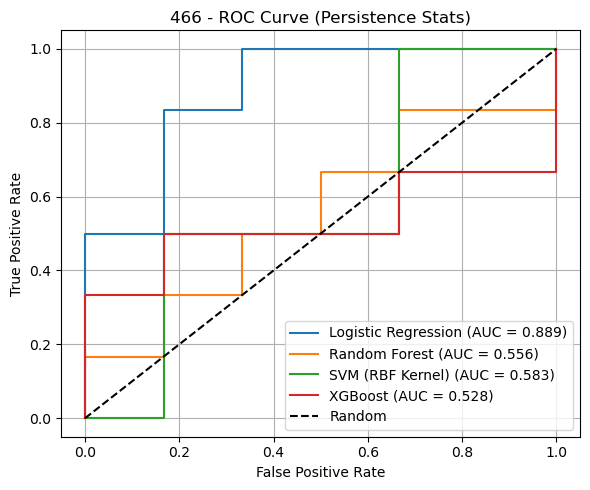


 Processing target: 548


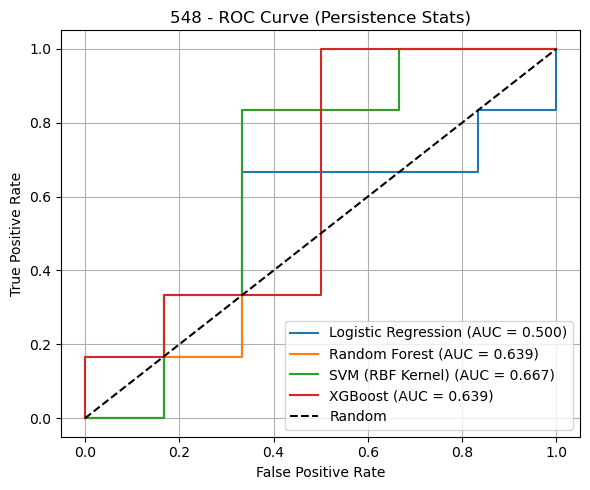


 Processing target: 600


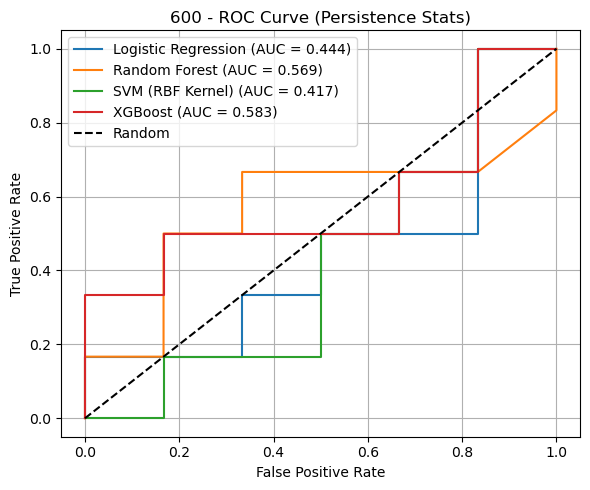


 Processing target: 644


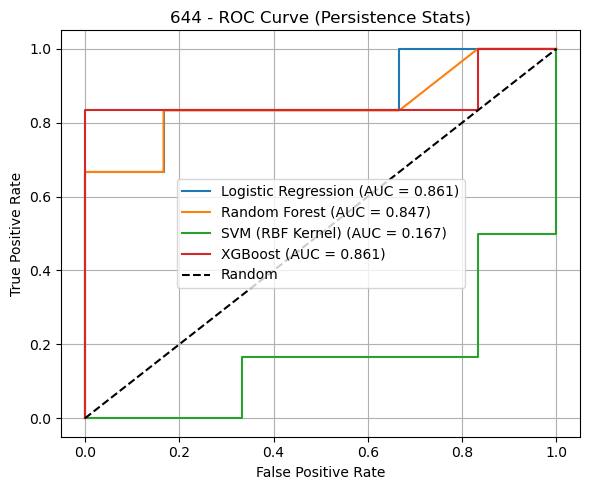


 Processing target: 652


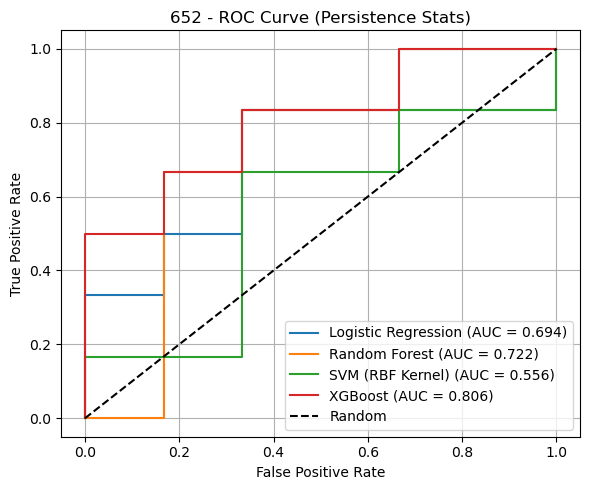


 Processing target: 689


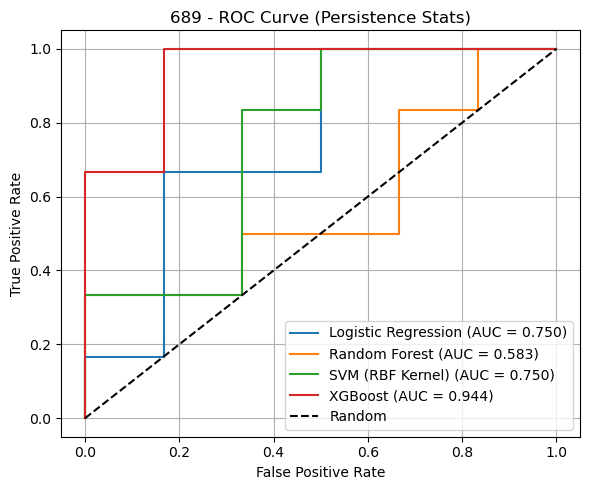


 Processing target: 692


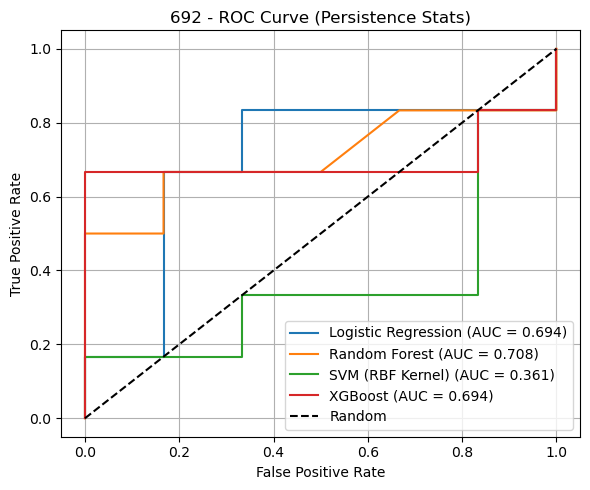


 Processing target: 712


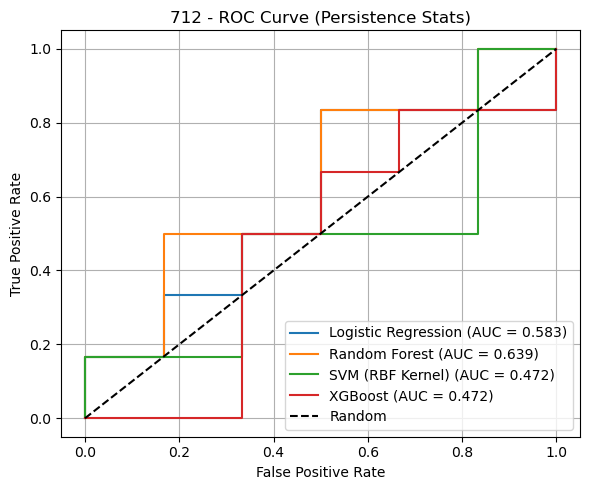


 Processing target: 713


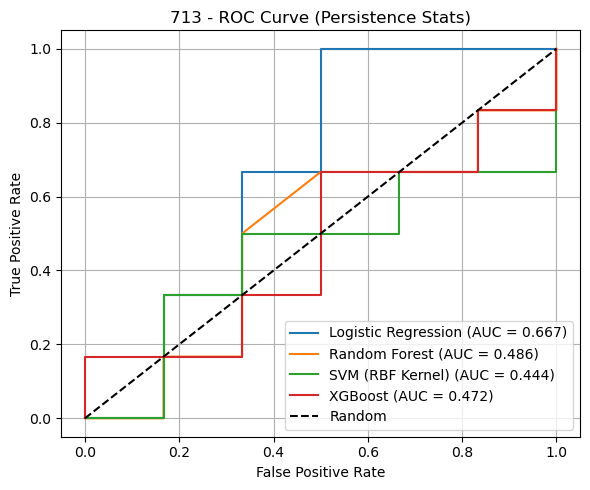


 Processing target: 733


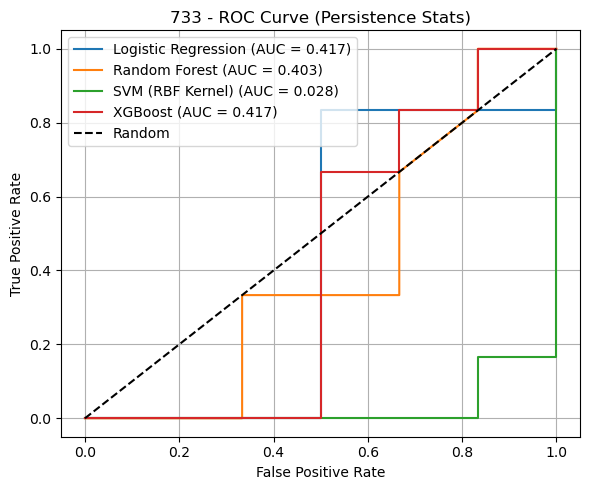


 Processing target: 737


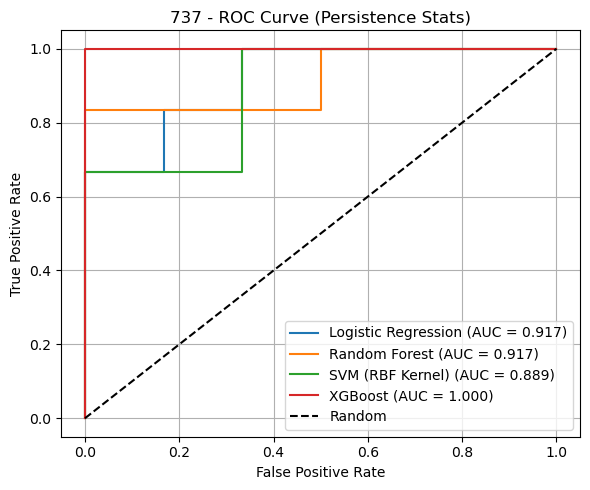


 Processing target: 810


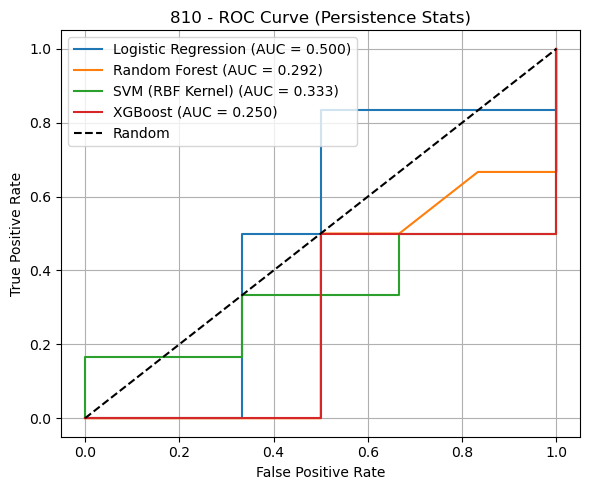


 Processing target: 832


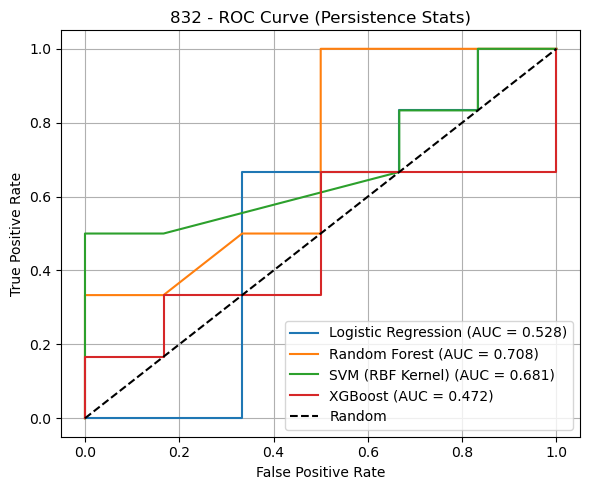


 Processing target: 846


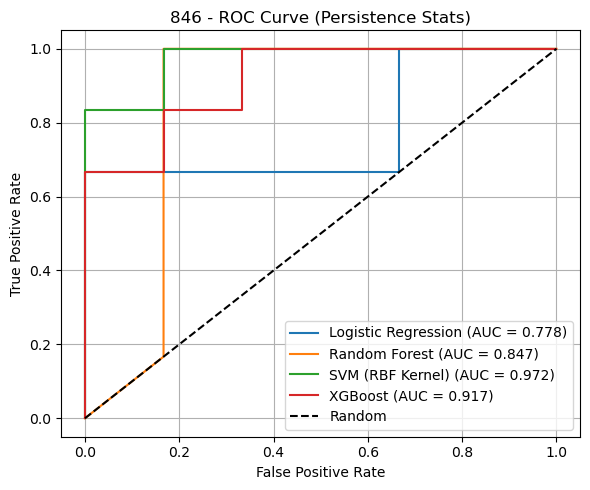


 Processing target: 852


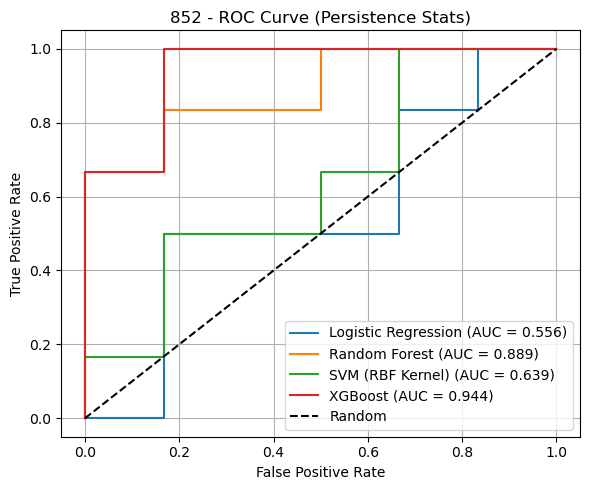


 Processing target: 858


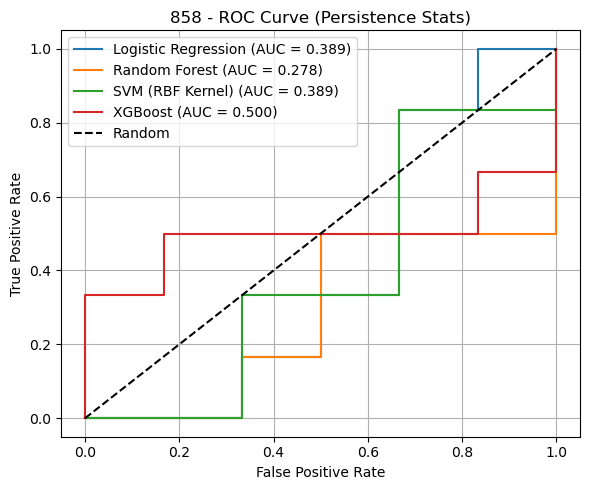


 Processing target: 859


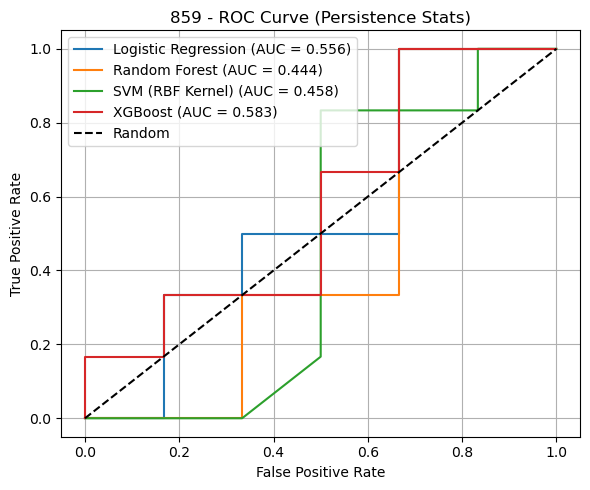

In [7]:
all_muv_results = {}

for target in targets:
    print(f"\n Processing target: {target.upper()}")
    lig_dir = os.path.join(targets_dir, target, 'ligs')
    decoy_dir = os.path.join(targets_dir, target, 'decoys')

    lig_files = os.listdir(lig_dir)
    decoy_files = os.listdir(decoy_dir)

    if len(lig_files) < 10 or len(decoy_files) < 10:
        print(f"Skipping {target} due to insufficient data")
        continue

    # Train-test split
    train_lig, test_lig = train_test_split(lig_files, test_size=0.2, random_state=42)
    train_dec, test_dec = train_test_split(decoy_files, test_size=0.2, random_state=42)

    # Balance decoys
    train_dec = resample(train_dec, replace=False, n_samples=len(train_lig), random_state=42)
    test_dec = resample(test_dec, replace=False, n_samples=len(test_lig), random_state=42)

    # Feature extraction
    train_lig_df = generate_persistence_stats_features(train_lig, lig_dir, 1)
    train_dec_df = generate_persistence_stats_features(train_dec, decoy_dir, 0)
    test_lig_df = generate_persistence_stats_features(test_lig, lig_dir, 1)
    test_dec_df = generate_persistence_stats_features(test_dec, decoy_dir, 0)

    if train_lig_df.empty or test_lig_df.empty:
        print(f"Skipping {target} due to empty feature sets")
        continue

    # Combine
    train_df = pd.concat([train_lig_df, train_dec_df]).sample(frac=1, random_state=42)
    test_df = pd.concat([test_lig_df, test_dec_df]).sample(frac=1, random_state=42)

    X_train = train_df.drop("label", axis=1)
    y_train = train_df["label"]
    X_test = test_df.drop("label", axis=1)
    y_test = test_df["label"]

    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)

    # Remove NaNs/Infs
    mask_train = np.isfinite(X_train_scaled).all(axis=1)
    mask_test = np.isfinite(X_test_scaled).all(axis=1)
    X_train_scaled, y_train = shuffle(X_train_scaled[mask_train], y_train[mask_train], random_state=42)
    X_test_scaled, y_test = shuffle(X_test_scaled[mask_test], y_test[mask_test], random_state=42)

    models = {
        "Logistic Regression": LogisticRegression(max_iter=1000),
        "Random Forest": RandomForestClassifier(n_estimators=100, random_state=42),
        "SVM (RBF Kernel)": SVC(probability=True),
        "XGBoost": XGBClassifier(use_label_encoder=False, eval_metric='logloss')
    }

    model_results = []
    plt.figure(figsize=(6, 5))

    for model_name, model in models.items():
        model.fit(X_train_scaled, y_train)
        probs = model.predict_proba(X_test_scaled)[:, 1]
        auc = roc_auc_score(y_test, probs)
        ef = enrichment_factor(y_test, probs, top_percent=30)

        fpr, tpr, _ = roc_curve(y_test, probs)
        plt.plot(fpr, tpr, label=f"{model_name} (AUC = {auc:.3f})")

        model_results.append({
            'Model': model_name,
            'AUC': round(auc, 4),
            'EF%': round(ef, 3)
        })

    plt.plot([0, 1], [0, 1], 'k--', label="Random")
    plt.title(f"{target.upper()} - ROC Curve (Persistence Stats)")
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    plt.show()

    result_df = pd.DataFrame(model_results)
    all_muv_results[target] = result_df


In [6]:
print("\n Summary of all AUC and EF results:")
for target, df in all_muv_results.items():
    print(f"\n--- {target.upper()} ---")
    display(df)


 Summary of all AUC and EF results:

--- 466 ---


,Model,AUC,EF%
0,Logistic Regression,0.8889,2.0
1,Random Forest,0.5556,2.0
2,SVM (RBF Kernel),0.4167,0.0
3,XGBoost,0.5278,2.0



--- 548 ---


,Model,AUC,EF%
0,Logistic Regression,0.5000,0.0
1,Random Forest,0.6389,0.0
2,SVM (RBF Kernel),0.6667,0.0
3,XGBoost,0.6389,2.0



--- 600 ---


,Model,AUC,EF%
0,Logistic Regression,0.4444,2.0
1,Random Forest,0.5694,2.0
2,SVM (RBF Kernel),0.4306,0.0
3,XGBoost,0.5833,2.0



--- 644 ---


,Model,AUC,EF%
0,Logistic Regression,0.8611,2.0
1,Random Forest,0.8472,2.0
2,SVM (RBF Kernel),0.2222,0.0
3,XGBoost,0.8611,2.0



--- 652 ---


,Model,AUC,EF%
0,Logistic Regression,0.6944,2.0
1,Random Forest,0.7222,0.0
2,SVM (RBF Kernel),0.5556,2.0
3,XGBoost,0.8056,2.0



--- 689 ---


,Model,AUC,EF%
0,Logistic Regression,0.7500,2.0
1,Random Forest,0.5833,2.0
2,SVM (RBF Kernel),0.7500,2.0
3,XGBoost,0.9444,2.0



--- 692 ---


,Model,AUC,EF%
0,Logistic Regression,0.6944,2.0
1,Random Forest,0.7083,2.0
2,SVM (RBF Kernel),0.3611,2.0
3,XGBoost,0.6944,2.0



--- 712 ---


,Model,AUC,EF%
0,Logistic Regression,0.5833,2.0
1,Random Forest,0.6389,2.0
2,SVM (RBF Kernel),0.4722,2.0
3,XGBoost,0.4722,0.0



--- 713 ---


,Model,AUC,EF%
0,Logistic Regression,0.6667,0.0
1,Random Forest,0.4861,0.0
2,SVM (RBF Kernel),0.4444,0.0
3,XGBoost,0.4722,2.0



--- 733 ---


,Model,AUC,EF%
0,Logistic Regression,0.4167,0.0
1,Random Forest,0.4028,0.0
2,SVM (RBF Kernel),0.0278,0.0
3,XGBoost,0.4167,0.0



--- 737 ---


,Model,AUC,EF%
0,Logistic Regression,0.9167,2.0
1,Random Forest,0.9167,2.0
2,SVM (RBF Kernel),0.8889,2.0
3,XGBoost,1.0000,2.0



--- 810 ---


,Model,AUC,EF%
0,Logistic Regression,0.5000,0.0
1,Random Forest,0.2917,0.0
2,SVM (RBF Kernel),0.3333,2.0
3,XGBoost,0.2500,0.0



--- 832 ---


,Model,AUC,EF%
0,Logistic Regression,0.5278,0.0
1,Random Forest,0.7083,2.0
2,SVM (RBF Kernel),0.3056,0.0
3,XGBoost,0.4722,2.0



--- 846 ---


,Model,AUC,EF%
0,Logistic Regression,0.7778,2.0
1,Random Forest,0.8472,0.0
2,SVM (RBF Kernel),0.9722,2.0
3,XGBoost,0.9167,2.0



--- 852 ---


,Model,AUC,EF%
0,Logistic Regression,0.5556,0.0
1,Random Forest,0.8889,2.0
2,SVM (RBF Kernel),0.6250,2.0
3,XGBoost,0.9444,2.0



--- 858 ---


,Model,AUC,EF%
0,Logistic Regression,0.3889,0.0
1,Random Forest,0.2778,0.0
2,SVM (RBF Kernel),0.6111,2.0
3,XGBoost,0.5000,2.0



--- 859 ---


,Model,AUC,EF%
0,Logistic Regression,0.5556,0.0
1,Random Forest,0.4444,0.0
2,SVM (RBF Kernel),0.5417,0.0
3,XGBoost,0.5833,2.0


## 5. Results Summary — Persistent Homology (H₀) Descriptor (MUV)

| Metric | Mean ± SD |
|---------|------------|
| **AUC** | 0.612 ± 0.071 |
| **EF%** | 1.219 ± 0.087 |

### Key Insights
- The H₀ descriptor provides a modest but clear improvement over the USR baseline, showing the value of capturing connected components.
- The performance indicates that basic topological information is more robust than purely geometric features on this difficult dataset. 